In [16]:
# ruff: noqa: E402
import pandas as pd

from jupyter_utils import JupyterUtils as JU

ju = JU()
DO_PROCESS = False

In [8]:
df_reviews = pd.read_csv("./data/raw/rotten_tomatoes_critic_reviews.csv")
df_movies = pd.read_csv("./data/raw/rotten_tomatoes_movies.csv")

In [45]:
# Remove reviews with null scores or content
df_reviews = df_reviews.dropna(subset=["review_score", "review_content"])

In [ ]:
from fractions import Fraction

import numpy as np

# Normalize scores to 0-1
GRADES = {
    "A+": 12,
    "A": 11,
    "A-": 10,
    "B+": 9,
    "B": 8,
    "B-": 7,
    "C+": 6,
    "C": 5,
    "C-": 4,
    "D+": 3,
    "D": 2,
    "D-": 1,
    "F": 0,
}


def normalize_score(score):
    """docstring for convert_score"""
    if "/" in score:
        try:
            num, den = score.split("/")
            num = float(Fraction(num))
            den = float(Fraction(den))
            if den > 0:
                return num / den
            else:
                return np.nan
        except Exception:
            return np.nan

    # Remove white spaces
    score = score.replace(" ", "")

    # Letter grade
    if score in GRADES:
        return GRADES[score] / 12

    # Some values are numeric without "/", ignore them
    return np.nan


df_reviews["score_norm"] = df_reviews["review_score"].apply(normalize_score)

df_reviews = df_reviews.dropna(subset=["score_norm"])

# Filter out erranous scores (e.g. 8/5)
df_reviews = df_reviews[df_reviews["score_norm"] <= 1]

In [46]:
# Transform to +ve -ve scores
df_reviews["polarity"] = df_reviews["score_norm"].apply(
    lambda x: 1 if x >= 0.7 else -1 if x <= 0.4 else None
)

df_reviews = df_reviews.dropna(subset=["polarity"])

In [62]:
ju.freq(df_reviews, "polarity")

,count,percentage,cumulative
polarity,,,
1,492890,65.10,65.10
-1,149683,19.77,84.87
0,114499,15.12,99.99


In [63]:
n = 50000  # number you want

pos_samples = df_reviews[df_reviews["polarity"] == 1].sample(n, random_state=42)
neg_samples = df_reviews[df_reviews["polarity"] == -1].sample(n, random_state=42)
neu_samples = df_reviews[df_reviews["polarity"] == 0].sample(n, random_state=42)

df_reviews_subset = pd.concat(
    [pos_samples, neg_samples, neu_samples], ignore_index=True
)
df_reviews_subset = df_reviews_subset.sample(frac=1).reset_index(drop=True)

In [38]:
df1 = pd.read_parquet("./data/raw/test-00000-of-00001.parquet")
df2 = pd.read_parquet("./data/raw/train-00000-of-00001.parquet")

df_reviews_imdb = pd.concat([df1, df2], ignore_index=True)

In [39]:
df_reviews_imdb.head()

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


In [64]:
%%execute_if DO_PROCESS or True
import spacy
from tqdm import tqdm

tqdm.pandas()  # enables df.progress_apply()

# Words to keep for sentiment analysis
keep_words = {
    "not",
    "no",
    "never",
    "none",
    "nothing",
    "neither",
    "nor",  # negations
    "very",
    "really",
    "too",
    "so",
    "quite",
    "extremely",  # intensifiers
    "least",
    "barely",
    "hardly",  # weakeners
}

# Stopwords to remove

# Download the English model
# python -m space en_core_web_sm
nlp = spacy.load("en_core_web_sm")

sentiment_stopwords = nlp.Defaults.stop_words - keep_words


# Remove stopwords and
def preprocess_review(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.lemma_.lower() not in sentiment_stopwords and token.is_alpha
    ]
    return " ".join(tokens)


df_reviews_subset["processed_review"] = df_reviews_subset[
    "review_content"
].progress_apply(preprocess_review)

# df_reviews["processed_review"] = df_reviews["review_content"].progress_apply(
#     preprocess_review
# )

# df_reviews.to_csv(
#     "./data/processed/rotten_tomatoes_critic_reviews.csv",
#     index=False,
# )

100%|█████████████████| 150000/150000 [17:24<00:00, 143.64it/s]


In [2]:
import pandas as pd

df_reviews_subset = pd.read_csv(
    "./data/processed/rotten_tomatoes_critic_reviews_subset.csv"
)
df_reviews_subset = pd.read_csv(
    "./data/processed/rotten_tomatoes_critic_reviews_subset.csv"
)

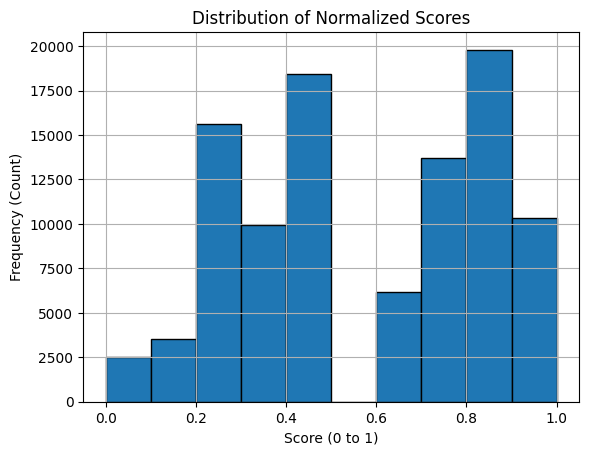

In [3]:

import matplotlib.pyplot as plt

df_reviews_subset["score_norm"].hist(bins=10, edgecolor="black")
plt.title("Distribution of Normalized Scores")
plt.xlabel("Score (0 to 1)")
plt.ylabel("Frequency (Count)")
plt.show()

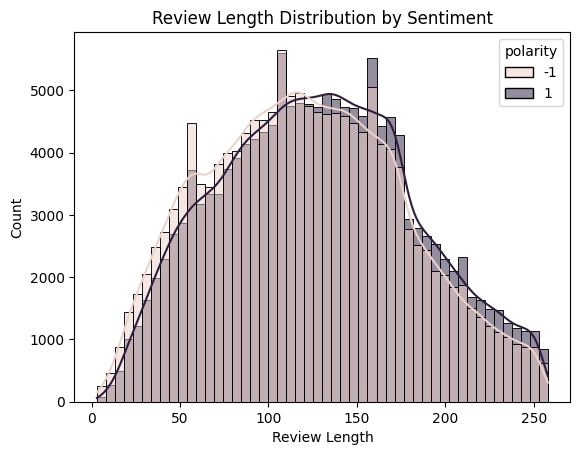

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

df_reviews_subset["review_length"] = df_reviews_subset["review_content"].apply(len)
sns.histplot(
    data=df_reviews_subset, x="review_length", hue="polarity", bins=50, kde=True
)
plt.title("Review Length Distribution by Sentiment")
plt.xlabel("Review Length")
plt.show()

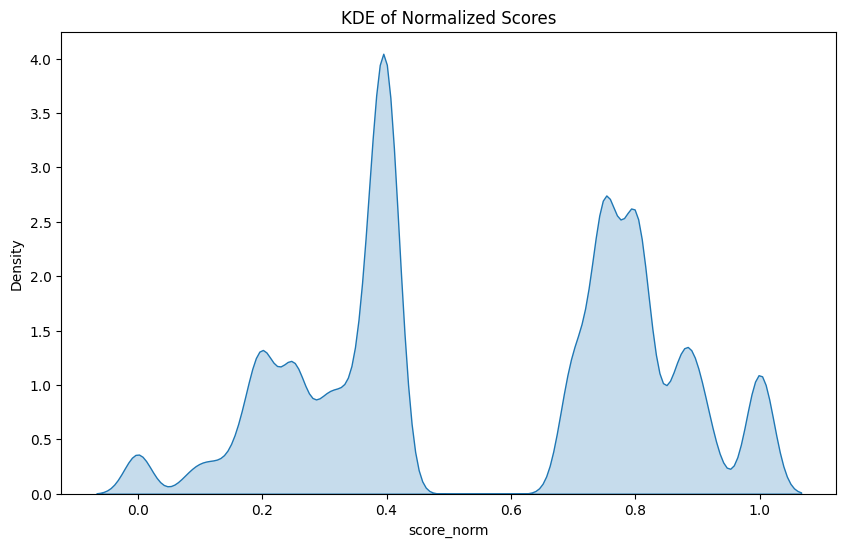

In [6]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_reviews_subset["score_norm"], fill=True)
plt.title("KDE of Normalized Scores")
plt.show()

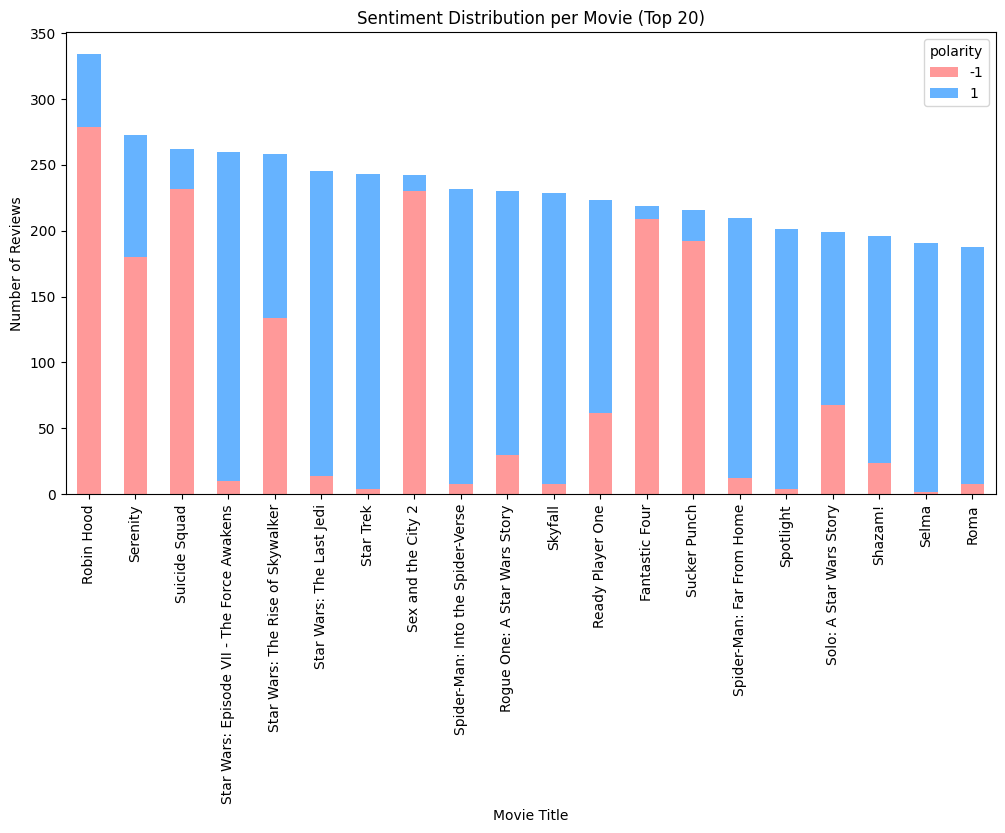

In [9]:

df = pd.merge(
    df_reviews_subset,
    df_movies,
    left_on="rotten_tomatoes_link",
    right_on="rotten_tomatoes_link",
    how="inner",
)
movie_sentiment = (
    df.groupby(["movie_title", "polarity"])["review_content"]
    .count()
    .unstack(fill_value=0)
)
top_movies = (
    movie_sentiment.sum(axis=1).sort_values(ascending=False).head(20)
)  # top 20 by total reviews

movie_sentiment_top = movie_sentiment.loc[top_movies.index]

colors = ["#ff9999", "#66b3ff"]
movie_sentiment_top.plot(kind="bar", stacked=True, figsize=(12, 6), color=colors)
plt.title("Sentiment Distribution per Movie (Top 20)")
plt.ylabel("Number of Reviews")
plt.xlabel("Movie Title")
plt.xticks(rotation=90)
plt.show()

In [17]:
import pandas as pd

df_reviews = pd.read_csv("./data/processed/rotten_tomatoes_critic_reviews.csv")
# Only care for +ve & -ve
df_reviews = df_reviews[df_reviews["polarity"] != 0]

# Downsample using polarity with least occurance
n = df_reviews["polarity"].value_counts().min()

pos_samples = df_reviews[df_reviews["polarity"] == 1].sample(n, random_state=42)
neg_samples = df_reviews[df_reviews["polarity"] == -1].sample(n, random_state=42)

df_reviews_subset = pd.concat([pos_samples, neg_samples], ignore_index=True)
df_reviews_subset = df_reviews_subset.sample(frac=1).reset_index(drop=True)

In [3]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Remove reviews with null scores or content
df_reviews_subset = df_reviews_subset.dropna(subset=["processed_review"])
X = df_reviews_subset["processed_review"]
y = df_reviews_subset["polarity"]


def evaluate_model_cv(model, vectorizer, X, y, cv_splits=5) -> List[Dict[str, int]]:
    """
    Perform manual KFold CV on a model + vectorizer.
    Returns a dict with aggregated metrics.
    """

    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    fold_metrics = []

    for fold, (train_idx, test_idx) in enumerate(
        tqdm(kf.split(X), total=kf.get_n_splits(), desc="Cross-validation")
    ):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Vectorize inside each fold
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)

        # Fit model
        model.fit(X_train_vec, y_train)

        # Predict
        preds = model.predict(X_test_vec)

        fold_metrics.append(
            {
                "fold": fold,
                "accuracy": accuracy_score(y_test, preds),
                "precision_macro": precision_score(
                    y_test, preds, average="macro", zero_division=0
                ),
                "recall_macro": recall_score(
                    y_test, preds, average="macro", zero_division=0
                ),
                "f1_macro": f1_score(y_test, preds, average="macro", zero_division=0),
            }
        )

    return fold_metrics


vectorizers = {
    "BOW": CountVectorizer(ngram_range=(1, 2)),
    "TF-IDF": TfidfVectorizer(ngram_range=(1, 2)),
}
from sklearn.naive_bayes import MultinomialNB

models = {
    "Logistic Rregression": LogisticRegression(C=1, max_iter=500),
    # 'Naive Bayes with Count Vectors': MultinomialNB(),
    # "Random Forest": RandomForestClassifier(),
}

results = []

for vec_name, vec in vectorizers.items():
    for model_name, model in models.items():
        print(f"Vectorizer: {vec_name}\nModel: {model_name}")
        folds = evaluate_model_cv(model, vec, X, y)
        for f in folds:
            results.append({"vectorizer": vec_name, "model": model_name, **f})

df_results = pd.DataFrame(results)

Vectorizer: BOW
Model: Logistic Regression


Cross-validation:   0%|          | 0/5 [00:16<?, ?it/s]


KeyboardInterrupt: 

In [11]:
summary = (
    df_results.groupby(["model", "vectorizer"])
    .agg(
        acc_mean=("accuracy", "mean"),
        acc_std=("accuracy", "std"),
        prec_mean=("precision_macro", "mean"),
        prec_std=("precision_macro", "std"),
        rec_mean=("recall_macro", "mean"),
        rec_std=("recall_macro", "std"),
        f1_mean=("f1_macro", "mean"),
        f1_std=("f1_macro", "std"),
    )
    .reset_index()
)
from IPython.display import display

summary = summary.round(4)
display(summary)
summary = (
    df_results.groupby(["model", "vectorizer"])
    .agg(mean_f1=("f1_macro", "mean"), std_f1=("f1_macro", "std"))
    .reset_index()
)
plt.errorbar(
    x=summary["model"] + " (" + summary["vectorizer"] + ")",
    y=summary["mean_f1"],
    yerr=summary["std_f1"],
    fmt="o",
)
plt.xticks(rotation=45)
plt.title("F1 mean ± std")
plt.show()

CROSS-VALIDATION RESULTS (Mean ± Std)


accuracy         f1_macro        
                                   mean     std     mean     std
vectorizer model                                                
BOW        Logistic Regression   0.8571  0.0020   0.8571  0.0020
           Naive Bayes           0.8527  0.0015   0.8526  0.0015
TF-IDF     Logistic Regression   0.8410  0.0023   0.8409  0.0023
           Naive Bayes           0.8528  0.0016   0.8527  0.0016

HOLDOUT TEST SET RESULTS


,vectorizer,model,accuracy,precision_macro,recall_macro,f1_macro
0,BOW,Logistic Regression,0.862836,0.862859,0.862837,0.862834
1,BOW,Naive Bayes,0.857589,0.857592,0.857589,0.857589
2,TF-IDF,Logistic Regression,0.845659,0.845899,0.845656,0.845631
3,TF-IDF,Naive Bayes,0.856821,0.856922,0.856819,0.856810


[[    0     0     0 ...   125 28763   106]
 [    0     0     0 ...     3 13172  5745]
 [    0     0     0 ...     3  1903   134]
 ...
 [    0     0     0 ...     3  7610 11489]
 [    0     0     0 ...     4   648  2822]
 [    0     0     0 ...  6138 29238  6239]]
X shape: (299366, 55), Y shape: (299366, 2)

Data split:
X_train shape: (191593, 55), Y_train shape: (191593, 2)
X_val shape: (47899, 55), Y_val shape: (47899, 2)
X_test shape: (59874, 55), Y_test shape: (59874, 2)

Percentages: Train=64.0%, Val=16.0%, Test=20.0%
Using device: cuda
LSTMSentimentModel(
  (embedding): Embedding(50000, 256, padding_idx=0)
  (spatial_dropout): Dropout2d(p=0.4, inplace=False)
  (lstm): LSTM(256, 196, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=392, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 14437778
Epoch 1/10 - loss: 0.5206 - acc: 0.7305 - val_loss: 0.3838 - val_acc: 0.8241
Epoch 2/10 - loss: 0.3668 - acc: 0.8326 - val_los

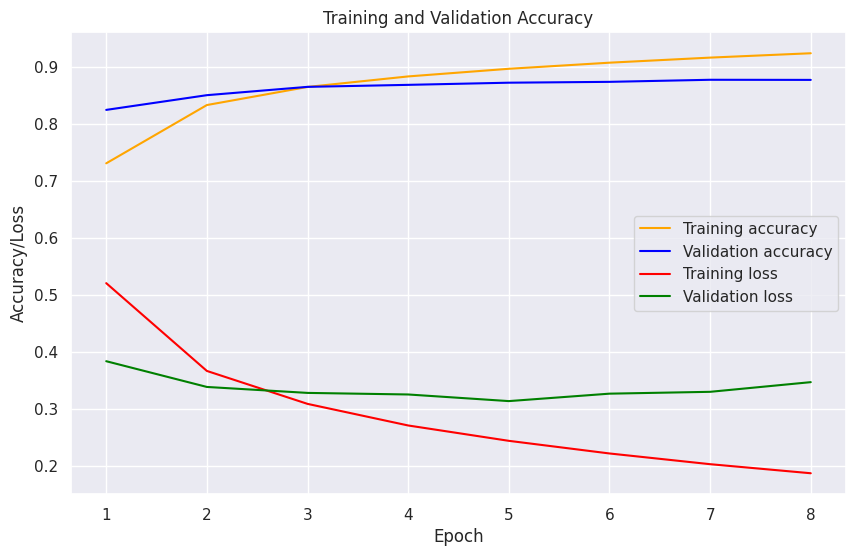


Test Set Evaluation:
Test Loss: 0.3095
Test Accuracy: 0.8719

Confusion Matrix:
[[26541  3396]
 [ 4244 25693]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     29937
           1       0.88      0.86      0.87     29937

    accuracy                           0.87     59874
   macro avg       0.87      0.87      0.87     59874
weighted avg       0.87      0.87      0.87     59874



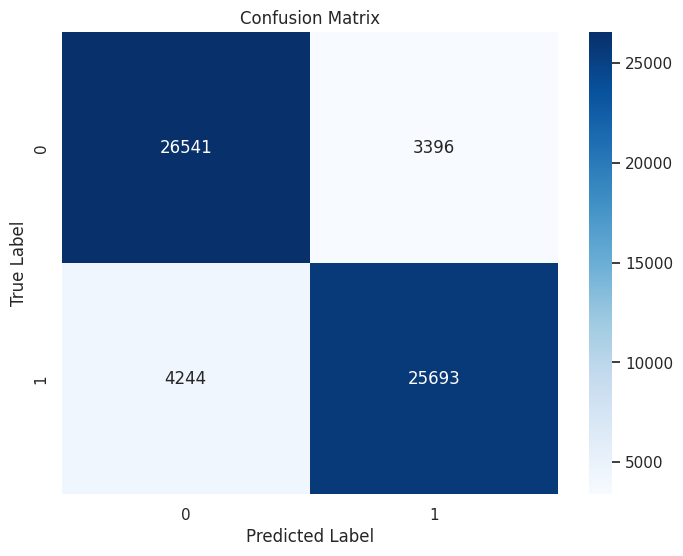

In [19]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ============================================================================
# 1. Text Preprocessing (Tokenizer replacement)
# ============================================================================


class TextTokenizer:
    def __init__(self, num_words=None):
        self.num_words = num_words
        self.word_index = {}
        self.index_word = {}

    def fit_on_texts(self, texts):
        """Build vocabulary from texts"""
        word_counts = Counter()
        for text in texts:
            words = text.lower().split()
            word_counts.update(words)

        # Get most common words
        most_common = word_counts.most_common(
            self.num_words - 1 if self.num_words else None
        )

        # Create word_index (starting from 1, 0 is reserved for padding)
        self.word_index = {word: idx + 1 for idx, (word, _) in enumerate(most_common)}
        self.index_word = {idx: word for word, idx in self.word_index.items()}

    def texts_to_sequences(self, texts):
        """Convert texts to sequences of integers"""
        sequences = []
        for text in texts:
            words = text.lower().split()
            seq = [
                self.word_index.get(word, 0)
                for word in words
                if word in self.word_index
            ]
            sequences.append(seq)
        return sequences


def pad_sequences(sequences, maxlen=None, padding="pre", value=0):
    """Pad sequences to the same length"""
    # Filter out empty sequences for maxlen calculation
    non_empty_sequences = [seq for seq in sequences if len(seq) > 0]

    if maxlen is None:
        if len(non_empty_sequences) > 0:
            maxlen = max(len(seq) for seq in non_empty_sequences)
        else:
            maxlen = 1  # Default to 1 if all sequences are empty

    padded = np.zeros((len(sequences), maxlen), dtype=np.int64)

    for i, seq in enumerate(sequences):
        if len(seq) == 0:
            # Empty sequence - will remain as zeros (padding)
            continue
        elif len(seq) > maxlen:
            if padding == "pre":
                padded[i] = seq[-maxlen:]
            else:
                padded[i] = seq[:maxlen]
        else:
            if padding == "pre":
                padded[i, -len(seq) :] = seq
            else:
                padded[i, : len(seq)] = seq

    return padded


# ============================================================================
# 2. Data Preprocessing
# ============================================================================
x = df_reviews_subset["review_content"].values

max_features = 50000

tokenizer = TextTokenizer(num_words=max_features)
tokenizer.fit_on_texts(x)
X = tokenizer.texts_to_sequences(x)
X = pad_sequences(X)
Y = pd.get_dummies(df_reviews_subset["polarity"]).values


print(X)
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

# ============================================================================
# 3. Train/Validation/Test Split
# ============================================================================

# First split: separate test set (80% train+val, 20% test)
X_temp, X_test, Y_temp, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# Second split: separate train and validation (80% train, 20% validation of the remaining 80%)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.2, random_state=42, stratify=Y_temp
)

print(f"\nData split:")
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")
print(
    f"\nPercentages: Train={len(X_train) / len(X) * 100:.1f}%, Val={len(X_val) / len(X) * 100:.1f}%, Test={len(X_test) / len(X) * 100:.1f}%"
)

# ============================================================================
# 4. Dataset Class
# ============================================================================


class SentimentDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.LongTensor(X)
        self.Y = torch.FloatTensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


# ============================================================================
# 5. LSTM Model
# ============================================================================

class LSTMSentimentModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_hidden, num_classes, dropout=0.2):
        super(LSTMSentimentModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.spatial_dropout = nn.Dropout2d(0.4)

        # Use num_layers=2 to make dropout work
        self.lstm = nn.LSTM(
            embed_dim, lstm_hidden, batch_first=True, num_layers=2, dropout=dropout,     bidirectional=True  # ← Better performance usually
        )

        self.fc = nn.Linear(lstm_hidden * 2, num_classes)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)

        embedded = embedded.permute(0, 2, 1).unsqueeze(3)
        embedded = self.spatial_dropout(embedded)
        embedded = embedded.squeeze(3).permute(0, 2, 1)

        lstm_out, (hidden, cell) = self.lstm(embedded)

        # hidden shape: (num_layers, batch, hidden)
        # Take the last layer's hidden state
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)

        output = self.fc(hidden)
        output = self.sigmoid(output)

        return output

# ============================================================================
# 6. Training Setup
# ============================================================================

embed_dim_out = 256
lstm_out = 196
num_classes = Y.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = LSTMSentimentModel(
    vocab_size=max_features,
    embed_dim=embed_dim_out,
    lstm_hidden=lstm_out,
    num_classes=num_classes,
    dropout=0.2,
).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

# ============================================================================
# 7. Create Data Loaders
# ============================================================================

train_dataset = SentimentDataset(X_train, Y_train)
val_dataset = SentimentDataset(X_val, Y_val)
test_dataset = SentimentDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ============================================================================
# 8. Training Loop with Early Stopping
# ============================================================================

criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.Adam(model.parameters())

# Early stopping parameters
patience = 3
min_delta = 1e-3
best_val_loss = float("inf")
patience_counter = 0
epochs = 10

history = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        train_correct += (predictions == batch_y).all(dim=1).sum().item()
        train_total += batch_y.size(0)

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            val_loss += loss.item()

            predictions = (outputs > 0.5).float()
            val_correct += (predictions == batch_y).all(dim=1).sum().item()
            val_total += batch_y.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Store history
    history["loss"].append(train_loss)
    history["accuracy"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_acc)

    print(
        f"Epoch {epoch + 1}/{epochs} - "
        f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - "
        f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}"
    )

    # Early stopping check
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch + 1}")
            break

# ============================================================================
# 9. Plot Training History
# ============================================================================

sns.set()
acc = history["accuracy"]
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history["accuracy"], "orange", label="Training accuracy")
plt.plot(epochs_range, history["val_accuracy"], "blue", label="Validation accuracy")
plt.plot(epochs_range, history["loss"], "red", label="Training loss")
plt.plot(epochs_range, history["val_loss"], "green", label="Validation loss")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="best")
plt.show()

# ============================================================================
# 10. Test Set Evaluation with Confusion Matrix
# ============================================================================

from sklearn.metrics import confusion_matrix, classification_report

# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        test_loss += loss.item()

        predictions = (outputs > 0.5).float()
        test_correct += (predictions == batch_y).all(dim=1).sum().item()
        test_total += batch_y.size(0)

        # Store predictions and labels for confusion matrix
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

test_loss /= len(test_loader)
test_acc = test_correct / test_total

print(f"\nTest Set Evaluation:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Convert to class labels (argmax for multi-class)
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

y_pred_classes = np.argmax(all_predictions, axis=1)
y_true_classes = np.argmax(all_labels, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

Loading tokenizer and model: distilbert-base-uncased
BERT model loaded successfully!
Number of samples: 1000
Y shape: (1000, 2)

Data split:
Train: 640 samples, Y_train shape: (640, 2)
Val: 160 samples, Y_val shape: (160, 2)
Test: 200 samples, Y_test shape: (200, 2)

Using device: cuda
BERTLSTMSentimentModel(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_f

Epoch 1/6 [Val]  : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.72it/s, loss=0.6917, acc=0.4188]



Epoch 1/6 Summary:
  Train - loss: 0.6940, acc: 0.2844
  Val   - loss: 0.6921, acc: 0.4188

  → Model saved (best val_loss: 0.6921)


Epoch 2/6 [Val]  : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.98it/s, loss=0.6906, acc=0.4500]



Epoch 2/6 Summary:
  Train - loss: 0.6923, acc: 0.3391
  Val   - loss: 0.6905, acc: 0.4500

  → Model saved (best val_loss: 0.6905)


Epoch 3/6 [Val]  : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.98it/s, loss=0.6894, acc=0.5062]



Epoch 3/6 Summary:
  Train - loss: 0.6903, acc: 0.4031
  Val   - loss: 0.6887, acc: 0.5062

  → Model saved (best val_loss: 0.6887)


Epoch 4/6 [Val]  : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.94it/s, loss=0.6881, acc=0.5687]



Epoch 4/6 Summary:
  Train - loss: 0.6891, acc: 0.4500
  Val   - loss: 0.6869, acc: 0.5687

  → Model saved (best val_loss: 0.6869)


Epoch 5/6 [Val]  : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.88it/s, loss=0.6866, acc=0.5938]



Epoch 5/6 Summary:
  Train - loss: 0.6869, acc: 0.5297
  Val   - loss: 0.6847, acc: 0.5938

  → Model saved (best val_loss: 0.6847)


Epoch 6/6 [Val]  : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.92it/s, loss=0.6847, acc=0.6125]



Epoch 6/6 Summary:
  Train - loss: 0.6842, acc: 0.5797
  Val   - loss: 0.6819, acc: 0.6125

  → Model saved (best val_loss: 0.6819)


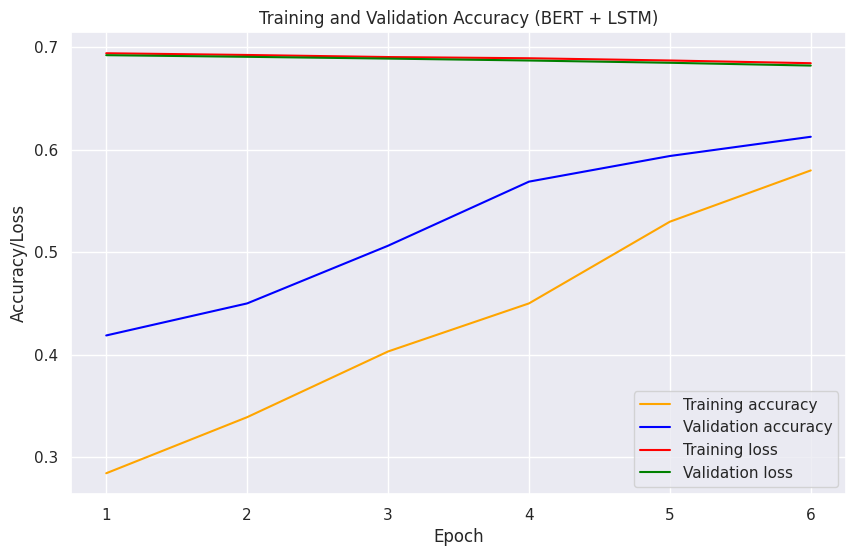

Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.33it/s, loss=0.6696, acc=0.5950]



Test Set Evaluation:
Test Loss: 0.6811
Test Accuracy: 0.5950

Confusion Matrix:
[[94  7]
 [62 37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.93      0.73       101
           1       0.84      0.37      0.52        99

    accuracy                           0.66       200
   macro avg       0.72      0.65      0.62       200
weighted avg       0.72      0.66      0.63       200



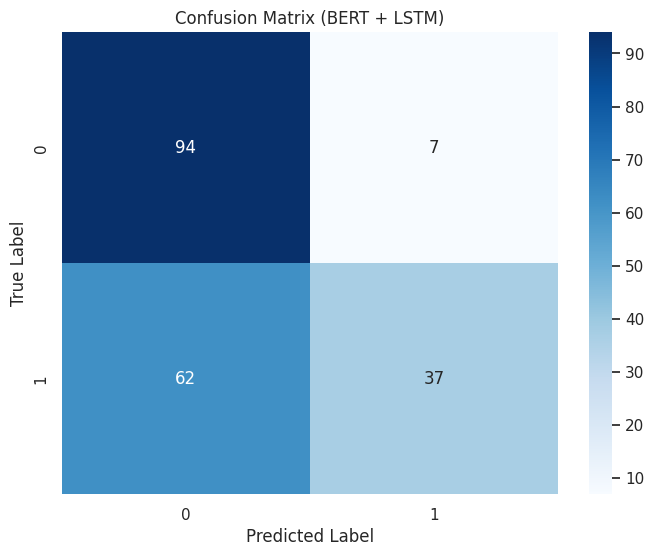

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel

# ============================================================================
# 1. BERT Setup
# ============================================================================

# Choose a pre-trained model
# Options: 'bert-base-uncased', 'roberta-base', 'distilbert-base-uncased' (faster)
model_name = "distilbert-base-uncased"  # Using DistilBERT for efficiency

print(f"Loading tokenizer and model: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

print("BERT model loaded successfully!")

# ============================================================================
# 2. Data Preprocessing
# ============================================================================
x = df_reviews_subset["review_content"]

Y = pd.get_dummies(df_reviews_subset["polarity"])

print(f"Number of samples: {len(x)}")
print(f"Y shape: {Y.shape}")

# ============================================================================
# 3. Train/Validation/Test Split
# ============================================================================

# First split: separate test set (80% train+val, 20% test)
X_temp, X_test, Y_temp, Y_test = train_test_split(
    x, Y, test_size=0.2, random_state=42, stratify=Y
)

# Second split: separate train and validation
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.2, random_state=42, stratify=Y_temp
)

print(f"\nData split:")
print(f"Train: {len(X_train)} samples, Y_train shape: {Y_train.shape}")
print(f"Val: {len(X_val)} samples, Y_val shape: {Y_val.shape}")
print(f"Test: {len(X_test)} samples, Y_test shape: {Y_test.shape}")

# ============================================================================
# 4. Dataset Class for BERT
# ============================================================================


class BERTSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        texts: array of text strings
        labels: numpy array of one-hot encoded labels
        tokenizer: BERT tokenizer
        max_length: maximum sequence length
        """
        self.texts = texts
        self.labels = torch.FloatTensor(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize with BERT tokenizer
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": label,
        }


# ============================================================================
# 5. LSTM Model with BERT Embeddings
# ============================================================================


class BERTLSTMSentimentModel(nn.Module):
    def __init__(self, bert_model, lstm_hidden, num_classes, dropout=0.2):
        super(BERTLSTMSentimentModel, self).__init__()

        self.bert = bert_model
        # DistilBERT outputs 768-dimensional vectors
        # BERT-base also outputs 768-dimensional vectors
        self.bert_output_dim = self.bert.config.hidden_size

        self.spatial_dropout = nn.Dropout(0.4)

        # Use num_layers=2 to make dropout work
        self.lstm = nn.LSTM(
            self.bert_output_dim, lstm_hidden, batch_first=True, num_layers=2, dropout=dropout,     bidirectional=True  # ← Better performance usually
        )    
        self.fc = nn.Linear(lstm_hidden * 2, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        # Shape: (batch, seq_len, 768)
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Use last hidden state
        embeddings = bert_output.last_hidden_state

        # Apply spatial dropout
        embeddings = self.spatial_dropout(embeddings)

        # LSTM
        lstm_out, (hidden, cell) = self.lstm(embeddings)

        # Use the last hidden state
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)

        # Dense layer
        output = self.fc(hidden)
        output = self.sigmoid(output)

        return output

# ============================================================================
# 6. Training Setup
# ============================================================================

lstm_out = 196
num_classes = Y.shape[1]
max_length = 128  # Maximum sequence length for BERT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

model = BERTLSTMSentimentModel(
    bert_model=bert_model, lstm_hidden=lstm_out, num_classes=num_classes, dropout=0.2
).to(device)

# Freeze BERT parameters (optional - comment out to fine-tune)
# Fine-tuning BERT will be slower but may give better results
for param in model.bert.parameters():
    param.requires_grad = False

print(model)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTrainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")

# ============================================================================
# 7. Create Data Loaders
# ============================================================================

train_dataset = BERTSentimentDataset(X_train, Y_train, tokenizer, max_length)
val_dataset = BERTSentimentDataset(X_val, Y_val, tokenizer, max_length)
test_dataset = BERTSentimentDataset(X_test, Y_test, tokenizer, max_length)

# Batch size - adjust based on your GPU memory
batch_size = 32  # Smaller batch size for BERT

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# ============================================================================
# 8. Training Loop with Early Stopping
# ============================================================================

criterion = nn.BCELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)

# Early stopping parameters
patience = 3
min_delta = 1e-3
best_val_loss = float("inf")
patience_counter = 0
epochs = 6

history = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]")

    for batch in train_pbar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        train_correct += (predictions == labels).all(dim=1).sum().item()
        train_total += labels.size(0)

       # Update progress bar with current loss
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{train_correct/train_total:.4f}'
        })
        
    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} [Val]  ")

    with torch.no_grad():
        for batch in val_pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            predictions = (outputs > 0.5).float()
            val_correct += (predictions == labels).all(dim=1).sum().item()
            val_total += labels.size(0)
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{val_correct/val_total:.4f}'
            })

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Store history
    history["loss"].append(train_loss)
    history["accuracy"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_acc)

    print(f"\nEpoch {epoch + 1}/{epochs} Summary:")
    print(f"  Train - loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Val   - loss: {val_loss:.4f}, acc: {val_acc:.4f}\n")

    # Early stopping check
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), "best_bert_model.pth")
        print(f"  → Model saved (best val_loss: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch + 1}")
            break

# ============================================================================
# 9. Plot Training History
# ============================================================================

sns.set()
acc = history["accuracy"]
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history["accuracy"], "orange", label="Training accuracy")
plt.plot(epochs_range, history["val_accuracy"], "blue", label="Validation accuracy")
plt.plot(epochs_range, history["loss"], "red", label="Training loss")
plt.plot(epochs_range, history["val_loss"], "green", label="Validation loss")
plt.title("Training and Validation Accuracy (BERT + LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="best")
plt.show()

# ============================================================================
# 10. Test Set Evaluation with Confusion Matrix
# ============================================================================

# Load best model
model.load_state_dict(torch.load("best_bert_model.pth"))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []

# Create progress bar for test
test_pbar = tqdm(test_loader, desc="Testing")

with torch.no_grad():
    for batch in test_pbar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        predictions = (outputs > 0.5).float()
        test_correct += (predictions == labels).all(dim=1).sum().item()
        test_total += labels.size(0)
        
        # Update progress bar with running metrics
        test_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{test_correct/test_total:.4f}'
        })
        
        # Store predictions and labels for confusion matrix
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_acc = test_correct / test_total

print(f"\nTest Set Evaluation:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Convert to class labels
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

y_pred_classes = np.argmax(all_predictions, axis=1)
y_true_classes = np.argmax(all_labels, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix (BERT + LSTM)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()